## Clustering using density

### Initialise data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import gaussian_kde

%matplotlib inline

In [26]:
i=0 #choose time value
dense_frac = 0.005
distance_threshold = 15.0

In [27]:
fc=pd.read_parquet('2017-11-07T22-00-00+00-00.1H.opp (3).parquet')
fc = fc[fc['q2.5'] == True]
dates = fc["date"].unique()
fc_dates = fc.loc[fc["date"] == dates[i]]
data = {'fsc_small': np.log(fc_dates['fsc_small']),
        'pe': np.log(fc_dates['pe']),
        'chl_small':np.log(fc_dates['chl_small'])}
df = pd.DataFrame(data)
selected_data = df.iloc[0:10000 , 0:3]

### Cluster

In [28]:
#separate dense and non-dense data
xyz = np.row_stack(([selected_data['fsc_small'], selected_data['pe'],selected_data['chl_small']]))
z = gaussian_kde(xyz)(xyz)
dense_data = selected_data[z>dense_frac*z.max()]
non_dense_data = selected_data.drop(dense_data.index)

In [29]:
#label non-dense data with agglomerative
clustering_model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',compute_full_tree=True, distance_threshold=distance_threshold)
clustering_model.fit(non_dense_data.iloc[:, 0:3])
data_labels = clustering_model.labels_

In [30]:
#label dense data with gmm
features=np.stack((dense_data['chl_small'],dense_data['pe'], dense_data['fsc_small']),axis=1);
gmm = GaussianMixture(n_components=2)
labels_gmm=gmm.fit_predict(features)

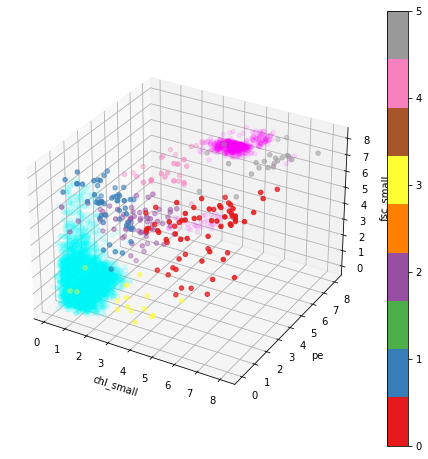

In [31]:
#plot 3D
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

p = ax.scatter3D(non_dense_data['chl_small'], non_dense_data['pe'], non_dense_data['fsc_small'], c=data_labels, cmap='Set1');
ax.scatter3D(dense_data['chl_small'], dense_data['pe'], dense_data['fsc_small'], c=labels_gmm, cmap='cool',alpha=0.1);

ax.set_xlabel('chl_small')
ax.set_ylabel('pe')
ax.set_zlabel('fsc_small')
fig.colorbar(p)

Text(0, 0.5, 'log pe')

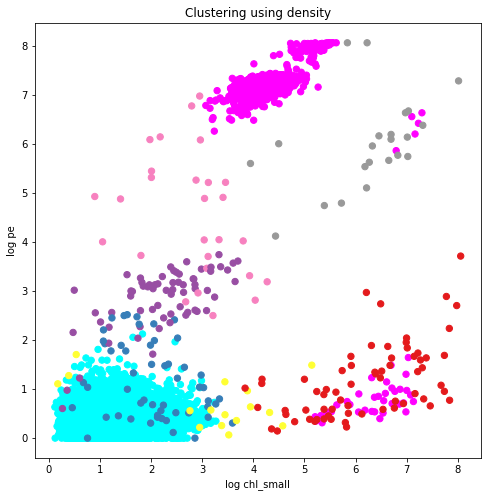

In [32]:
#plot 2D
fig = plt.figure(figsize=(8,8))
plt.scatter(dense_data['chl_small'], dense_data['pe'],40,c=labels_gmm, cmap='cool')
plt.scatter(non_dense_data['chl_small'], non_dense_data['pe'],40,c=data_labels, cmap='Set1')

plt.title('Clustering using density')
plt.xlabel("log chl_small")
plt.ylabel('log pe')